<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/2025_movement_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# movement value and plots

In [ ]:
%load_ext cuml.accel
%load_ext cudf.pandas

<IPython.core.display.Javascript object>

[2025-04-23 00:55:25.125] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-23 00:55:49.996] [CUML] [info] cuML: Installed accelerator for umap.
[2025-04-23 00:55:50.095] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-04-23 00:55:50.095] [CUML] [info] cuML: Successfully initialized accelerator.


/usr/local/lib/python3.11/dist-packages/cudf/pandas/__init__.py:65: UserWarning: cudf.pandas detected an already configured memory resource, ignoring 'CUDF_PANDAS_RMM_MODE'=managed_pool
  warnings.warn(


In [ ]:
!pip install -U pandas
!pip install catboost
!pip install pybaseball


<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 136.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 56.7 MB/s eta 0:00:00


In [ ]:
# some of this is boiler plate and can be reduced.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import QuantileTransformer, minmax_scale
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr, spearmanr, percentileofscore
import catboost as cb
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

project_dir = 'drive/My Drive/2024-MLB'

<IPython.core.display.Javascript object>

# data load and model

In [ ]:
df = pd.DataFrame()
for fn in [x for x in os.listdir(project_dir) if '-pbp.csv' in x]:
  _df = pd.read_csv(f'{project_dir}/{fn}')
  df = pd.concat([df, _df])
df = df.reset_index(drop=True)
df['is_lhp'] = df['p_throws'].map({'R':0, 'L':1})
df['spin_axis_adj'] = df['spin_axis'].copy()
df.loc[df['is_lhp']==1, 'spin_axis_adj'] = df.loc[df['is_lhp']==1, 'spin_axis_adj'].mul(-1).add(360)
df['pfx_x_adj'] = df['pfx_x'].copy()
df.loc[df['is_lhp']==1, 'pfx_x_adj'] = df.loc[df['is_lhp']==1, 'pfx_x_adj'].mul(-1)
x = df.loc[:, ['on_3b', 'on_2b', 'on_1b']].isna().sum(axis=1)
x = x.replace([0,1,2,3], [0,0,0,1])
df['bases_empty'] = x
lo = df.loc[(df['description']=='hit_into_play') & (df['bases_empty']==1) & (df['delta_run_exp']<0), 'delta_run_exp'].mean()
hi = df.loc[(df['description']=='hit_into_play') & (df['bases_empty']==1) & (df['delta_run_exp']>=0), 'delta_run_exp'].mean()
df['stuff_rv'] = df['delta_run_exp'].copy()
df.loc[(df['description']=='hit_into_play') & (df['bases_empty']==1) & (df['delta_run_exp']<0), 'stuff_rv'] = lo
df.loc[(df['description']=='hit_into_play') & (df['bases_empty']==1) & (df['delta_run_exp']>=0), 'stuff_rv'] = hi
_df = df.loc[df['pitch_type'].isin(['FF','SI']), ['game_year','pitcher','release_speed','pfx_x','pfx_z']].groupby(['game_year','pitcher'],as_index=False).mean().rename(columns={'release_speed':'release_speed_avg','pfx_x':'pfx_x_avg','pfx_z':'pfx_z_avg'})
df = df.merge(_df)
for col in ['release_speed','pfx_x','pfx_z']:
  df[f"{col}_diff"] = df[col].sub(df[f"{col}_avg"])
df.shape

<IPython.core.display.Javascript object>

(2286841, 124)

In [ ]:
feats = [
    'release_spin_rate', 'spin_axis_adj', 'release_pos_x', 'release_pos_z',
    'release_extension', 'is_lhp', 'arm_angle'
]
targets = ['pfx_x_adj', 'pfx_z']
model_data = df.dropna(subset=feats+targets)
model_data.shape

<IPython.core.display.Javascript object>

(2143888, 124)

In [ ]:
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
preds = pd.DataFrame()

for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, loss_function='MultiRMSE',task_type="GPU")
  model.fit(train[feats], train[targets])
  preds = pd.concat([preds, pd.DataFrame(model.predict(test.loc[:, feats]), index=test.index, columns=targets)])

preds.columns = ['pfx_x_adj_cb', 'pfx_z_cb']
df = pd.concat([df, preds], axis=1)
df[f'ssw_x'] = df['pfx_x_adj'].sub(df['pfx_x_adj_cb'])
df[f'ssw_z'] = df['pfx_z'].sub(df['pfx_z_cb'])
df.to_csv(f'{project_dir}/ssw.csv',index=False)

<IPython.core.display.Javascript object>

In [ ]:
id_feats = ['game_year','pitcher', 'player_name', 'pitch_type','pitch_name']
feats = ['release_speed', 'pfx_x_adj','pfx_z','release_pos_x','release_pos_z',
         'release_extension', 'release_speed_diff',
         'pfx_x_diff','pfx_z_diff','release_spin_rate', 'spin_axis_adj',
         'ssw_x', 'ssw_z']
target = 'stuff_rv'
model_data = df.loc[(df['bases_empty']==1) & (df['release_speed']>70) & (df['pfx_x'].between(-2,2)) & (df['pfx_z'].between(-2,2)) & (df['plate_x'].between(-1.667,1.667))].dropna(subset=id_feats+feats+[target])
holdout = df.loc[~df.index.isin(model_data.index.values)].dropna(subset=feats+[target])

model_data.shape, holdout.shape

<IPython.core.display.Javascript object>

((1171509, 128), (972223, 128))

In [ ]:
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
s = pd.DataFrame()

for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE',task_type="GPU")
  model.fit(train.loc[:, feats], train[target])
  s = pd.concat([s, pd.Series(model.predict(test.loc[:, feats]), index=test.index)])

model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE',task_type="GPU")
model.fit(model_data.loc[:, feats], model_data[target])
s = pd.concat([s, pd.Series(model.predict(holdout.loc[:, feats]), index=holdout.index)])

df['stuff_xrv'] = s
df.to_csv(f'{project_dir}/stuff_xrv.csv',index=False)

<IPython.core.display.Javascript object>

# viz

In [ ]:
df = pd.read_csv(f'{project_dir}/stuff_xrv.csv')
df.shape

<IPython.core.display.Javascript object>

(2286841, 129)

<IPython.core.display.Javascript object>

,stuff_xrv
count,2143732.000
mean,0.000
std,0.010
min,-0.113
25%,-0.006
50%,0.000
75%,0.007
max,0.285


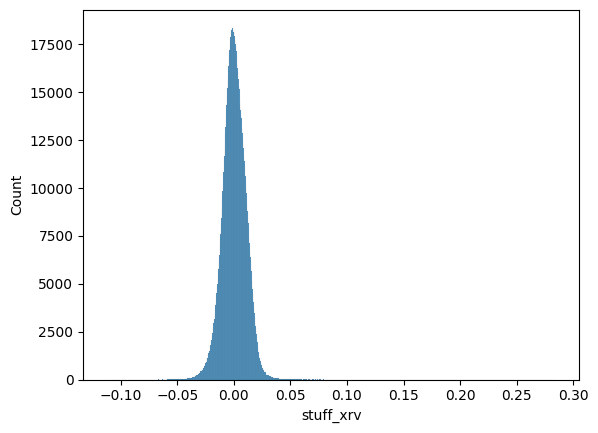

In [ ]:
sns.histplot(df['stuff_xrv'])
df['stuff_xrv'].describe().round(3)

In [ ]:
df['stuff_xrv'] = df['stuff_xrv'].mul(-1)
move = df['stuff_xrv'].min()
move = 1.1*abs(move)
x = df['stuff_xrv'].add(move)
mid = x.median()
df['stuff+'] = (x.div(mid)).mul(100)
z = (x.sub(mid)).div(x.std())

<IPython.core.display.Javascript object>

In [ ]:
z.describe().round(3)

<IPython.core.display.Javascript object>

,stuff_xrv
count,2143732.000
mean,-0.012
std,1.000
min,-27.187
25%,-0.653
50%,-0.000
75%,0.601
max,10.817


<IPython.core.display.Javascript object>

,stuff+
count,2143732.000
mean,99.960
std,3.344
min,9.095
1%,92.323
5%,94.739
10%,95.862
20%,97.264
25%,97.817
33%,98.598


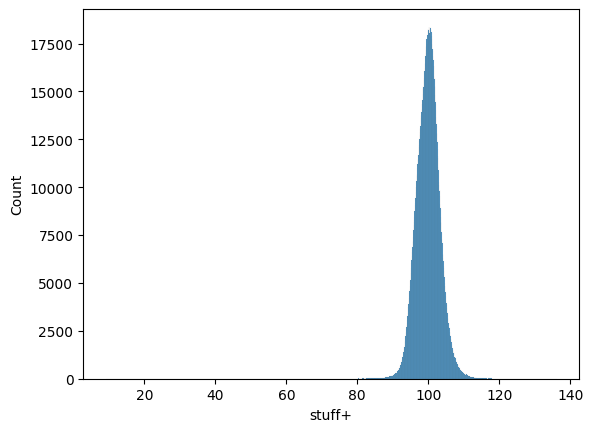

In [ ]:
sns.histplot(df['stuff+'])
df['stuff+'].describe(percentiles=[.01,.05,.1,.2,.25,.33,.5,.66,.75,.8,.9,.95,.99]).round(3)

<IPython.core.display.Javascript object>

,stuff_xrv
count,2143732.000
mean,99.881
std,10.000
min,-171.872
1%,77.042
5%,84.265
10%,87.626
20%,91.818
25%,93.470
33%,95.808


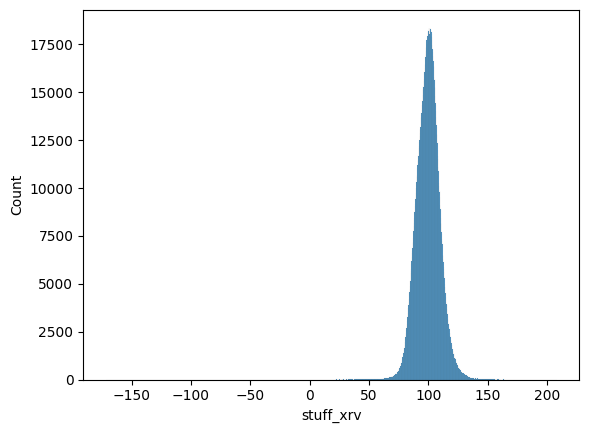

In [ ]:
a = (z.mul(10)).add(100)
df['stuff++'] = a
sns.histplot(a)
a.describe(percentiles=[.01,.05,.1,.2,.25,.33,.5,.66,.75,.8,.9,.95,.99]).round(3)

<IPython.core.display.Javascript object>

,0
count,2143732.000
mean,101.054
std,21.371
min,0.000
1%,55.333
5%,68.449
10%,75.453
20%,83.948
25%,87.180
33%,91.711


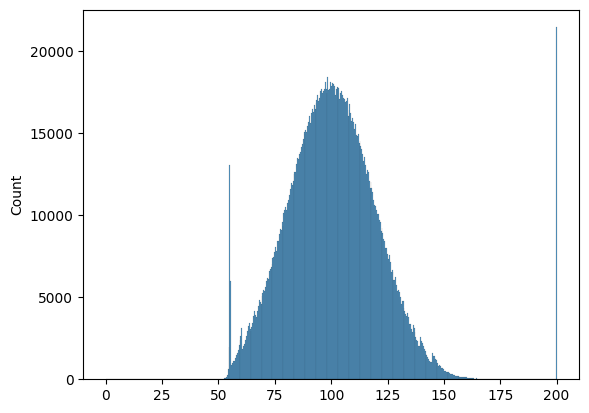

In [ ]:
z2 = z.dropna()
qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
z3 = z2.quantile(np.arange(0,1,0.01)).round(3)
qt.fit(z3.to_frame())
a = qt.transform(z2.to_frame())
a = pd.DataFrame(a, index=z2.index)
a = pd.Series(minmax_scale(a[0],feature_range=(0,200)), index=a.index)
df['stuff+++'] = a
sns.histplot(a)
a.describe(percentiles=[.01,.05,.1,.2,.25,.33,.5,.66,.75,.8,.9,.95,.99]).round(3)

<IPython.core.display.Javascript object>

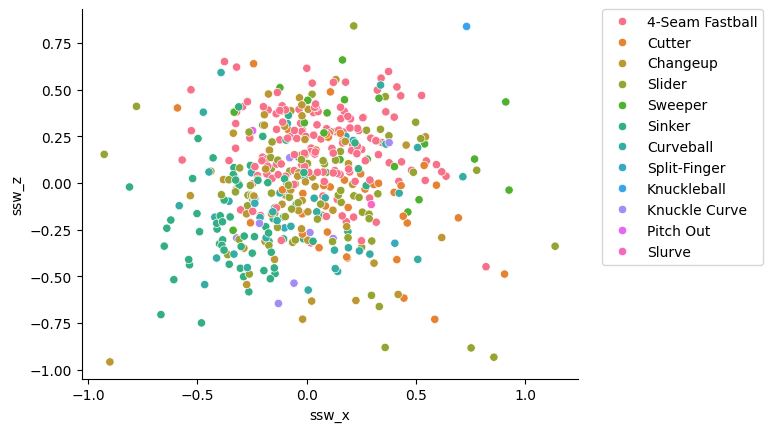

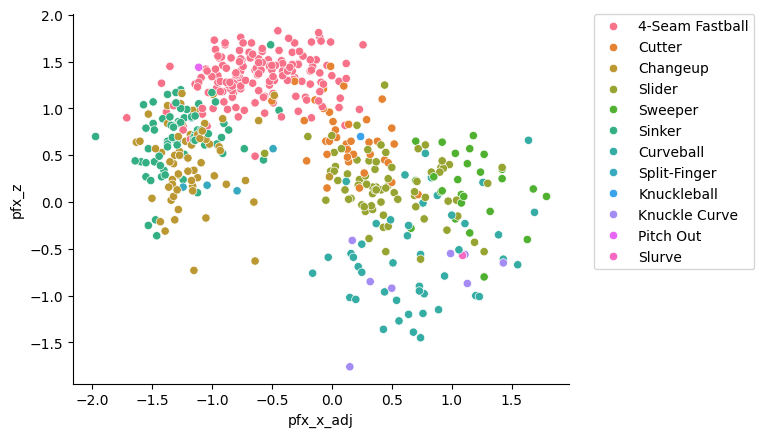

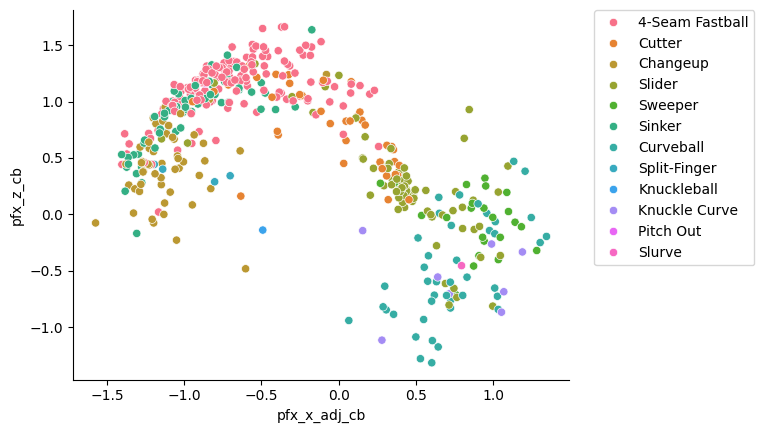

In [ ]:
df_plt = df.sample(500)

sns.scatterplot(data=df_plt, x='ssw_x', y='ssw_z', hue='pitch_name')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


sns.scatterplot(data=df_plt, x='pfx_x_adj', y='pfx_z', hue='pitch_name')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


sns.scatterplot(data=df_plt, x='pfx_x_adj_cb', y='pfx_z_cb', hue='pitch_name')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


<IPython.core.display.Javascript object>

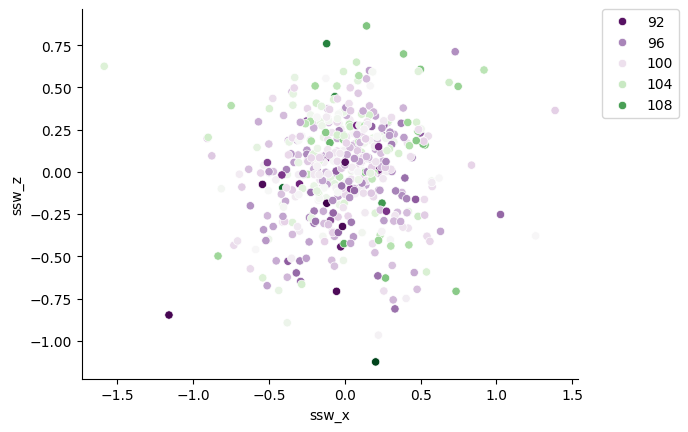

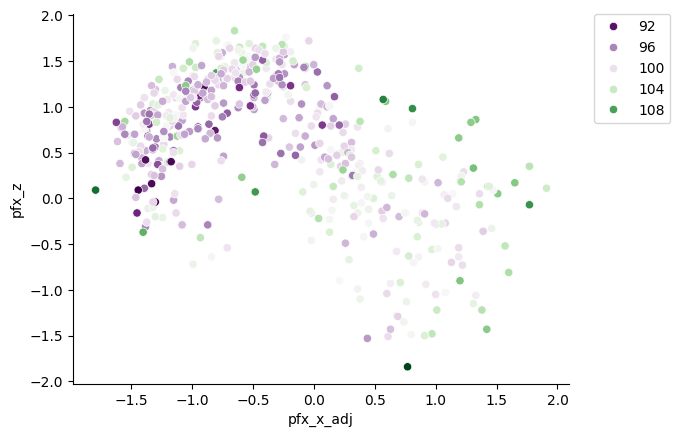

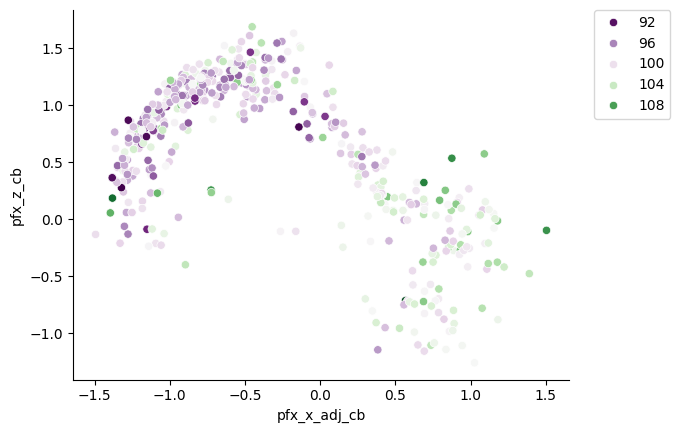

In [ ]:
df_plt = df.sample(500)
hue = 'stuff+'

sns.scatterplot(data=df_plt, x='ssw_x', y='ssw_z', hue=hue, palette='PRGn')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


sns.scatterplot(data=df_plt, x='pfx_x_adj', y='pfx_z', hue=hue, palette='PRGn')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


sns.scatterplot(data=df_plt, x='pfx_x_adj_cb', y='pfx_z_cb', hue=hue, palette='PRGn')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


In [ ]:
df.loc[:, ['pitch_name','pitch_type']].drop_duplicates()

<IPython.core.display.Javascript object>

,pitch_name,pitch_type
0,Curveball,CU
1,4-Seam Fastball,FF
12,Sweeper,ST
45,Slider,SL
47,Sinker,SI
97,Knuckle Curve,KC
103,Changeup,CH
104,Cutter,FC
106,Split-Finger,FS
1333,Pitch Out,PO


<IPython.core.display.Javascript object>

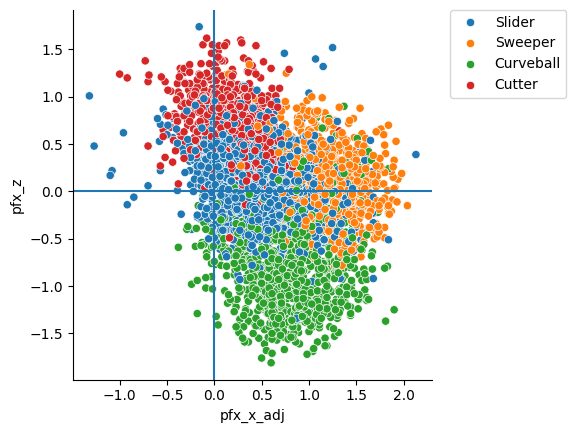

In [ ]:
sns.scatterplot(data=df.loc[df['pitch_type'].isin(['SL','FC','ST','CU'])].sample(5000),
                x='pfx_x_adj', y='pfx_z', hue='pitch_name')
plt.axhline(0)
plt.axvline(0)
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

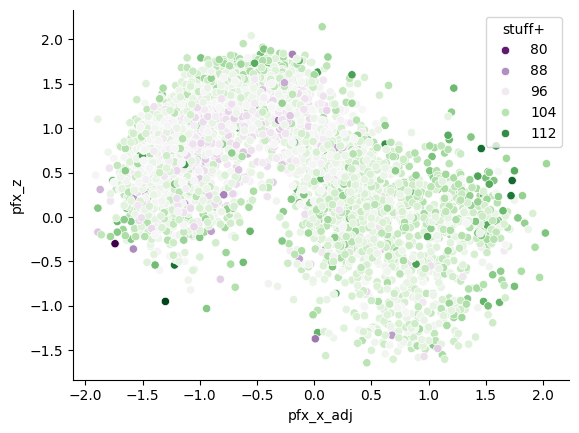

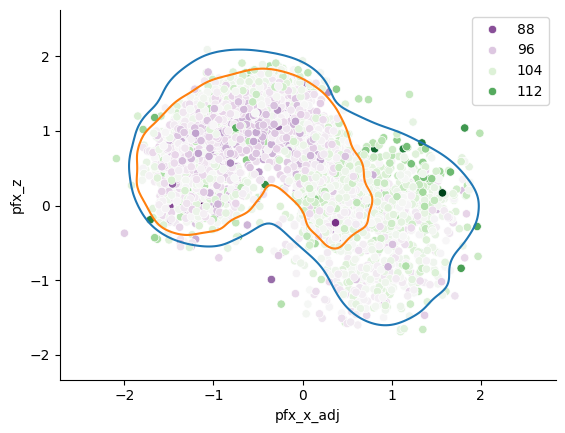

In [ ]:
df_plt = df.loc[df['pitch_type'].isin(['FF','SI','FC','SL','ST','CU','FS','CH'])]

# df_plt = df.loc[df['pitch_type'].isin(['SI'])]
hue = 'stuff+'

df_plt_avg = df_plt.loc[df_plt[hue].between(df_plt[hue].quantile(.33), df_plt[hue].quantile(.66))]
df_plt_hi = df_plt.loc[df_plt[hue]>df_plt[hue].quantile(.75)]
df_plt_lo = df_plt.loc[df_plt[hue]<df_plt[hue].quantile(.25)]


sns.scatterplot(data=df_plt.sample(5000),
                x='pfx_x_adj', y='pfx_z',hue=hue, palette='PRGn')
sns.despine()
plt.show()


# sns.kdeplot(data=df_plt_avg.sample(5000),
#             x='pfx_x_adj', y='pfx_z',levels=2, label='avg')
sns.kdeplot(data=df_plt_hi.sample(10000),
            x='pfx_x_adj', y='pfx_z',levels=2, label='hi',zorder=2)
sns.kdeplot(data=df_plt_lo.sample(10000),
            x='pfx_x_adj', y='pfx_z',levels=2, label='lo',zorder=2)
sns.scatterplot(data=df_plt.sample(5000),
                x='pfx_x_adj', y='pfx_z',hue=hue, palette='PRGn',zorder=1)
plt.legend()
sns.despine()
plt.show()


<IPython.core.display.Javascript object>

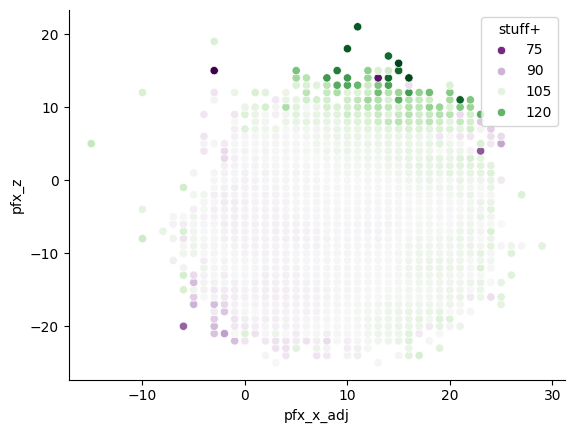

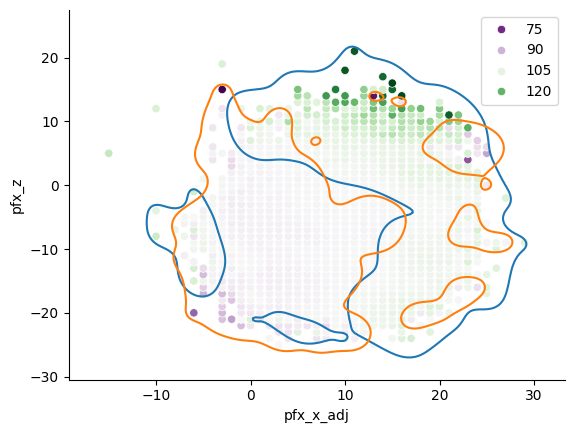

In [ ]:
hue = 'stuff+'

df_plt = df.loc[df['pitch_type']=='CU']
df_plt['pfx_x_adj'] = df_plt['pfx_x_adj'].mul(12).round(0)
df_plt['pfx_z'] = df_plt['pfx_z'].mul(12).round(0)
df_plt = df_plt.loc[:, ['pfx_x_adj','pfx_z',hue]].groupby(['pfx_x_adj','pfx_z'], as_index=False).mean()

df_plt_avg = df_plt.loc[df_plt[hue].between(df_plt[hue].quantile(.33), df_plt[hue].quantile(.66))]
df_plt_hi = df_plt.loc[df_plt[hue]>df_plt[hue].quantile(.66)]
df_plt_lo = df_plt.loc[df_plt[hue]<df_plt[hue].quantile(.33)]


sns.scatterplot(data=df_plt,
                x='pfx_x_adj', y='pfx_z',hue=hue, palette='PRGn')
sns.despine()
plt.show()


# sns.kdeplot(data=df_plt_avg.sample(5000),
#             x='pfx_x_adj', y='pfx_z',levels=2, label='avg')
sns.kdeplot(data=df_plt_hi,bw_adjust=.5,
            x='pfx_x_adj', y='pfx_z',levels=2, label='hi',zorder=2)
sns.kdeplot(data=df_plt_lo,bw_adjust=.5,
            x='pfx_x_adj', y='pfx_z',levels=2, label='lo',zorder=2)
sns.scatterplot(data=df_plt,
                x='pfx_x_adj', y='pfx_z',hue=hue, palette='PRGn',zorder=1)
plt.legend()
sns.despine()
plt.show()


In [ ]:
pts = ['FF','SI','FC','SL','ST','CU','FS','CH']
s = pd.Series()
for pt in tqdm(pts,total=len(pts), leave=True):
  df_c = df.loc[df['pitch_type']==pt]
  df_plt_hi = df_c.loc[df_c[hue]>df_c[hue].quantile(.66)].sample(frac=.25)
  df_plt_lo = df_c.loc[df_c[hue]<df_c[hue].quantile(.33)].sample(frac=.25)

  _df = df_plt_hi
  kde = KernelDensity(bandwidth=.2,kernel='gaussian')  # Adjust bandwidth as needed
  kde.fit(_df.loc[:, ['pfx_x_adj', 'pfx_z']])

  # Evaluate the KDE on a grid of points
  x_grid = np.linspace(_df['pfx_x_adj'].min(), _df['pfx_x_adj'].max(), 100)
  y_grid = np.linspace(_df['pfx_z'].min(), _df['pfx_z'].max(), 100)
  X, Y = np.meshgrid(x_grid, y_grid)
  xy = np.vstack([X.ravel(), Y.ravel()]).T
  Z = np.exp(kde.score_samples(xy))
  Z = Z.reshape(X.shape)
  contour_level = np.percentile(Z, 95)

  _df2 = df_c.loc[:, ['pfx_x_adj', 'pfx_z']].dropna()
  kde_samples = kde.score_samples(_df2)
  density_values = np.exp(kde_samples)

  # Filter the DataFrame based on the contour level
  _df2['hi'] = 0
  _df2.loc[density_values >= contour_level, 'hi'] = 1

  _df = df_plt_lo
  kde = KernelDensity(bandwidth=.2,kernel='gaussian')  # Adjust bandwidth as needed
  kde.fit(_df.loc[:, ['pfx_x_adj', 'pfx_z']])

  # Evaluate the KDE on a grid of points
  x_grid = np.linspace(_df['pfx_x_adj'].min(), _df['pfx_x_adj'].max(), 100)
  y_grid = np.linspace(_df['pfx_z'].min(), _df['pfx_z'].max(), 100)
  X, Y = np.meshgrid(x_grid, y_grid)
  xy = np.vstack([X.ravel(), Y.ravel()]).T
  Z = np.exp(kde.score_samples(xy))
  Z = Z.reshape(X.shape)
  contour_level = np.percentile(Z, 95)

  _df1 = df_c.loc[:, ['pfx_x_adj', 'pfx_z']].dropna()
  kde_samples = kde.score_samples(_df1)

  density_values = np.exp(kde_samples)

  # Filter the DataFrame based on the contour level
  _df1['lo'] = 0
  _df1.loc[density_values >= contour_level, 'lo'] = 1

  df_c['lo'] = np.nan
  df_c['hi'] = np.nan
  df_c['lo'] = _df2['lo']
  df_c['hi'] = _df1['hi']
  df_c['class'] = 0
  df_c.loc[(df_c['lo']==1) & (df_c['hi']==1), 'class'] = 0
  df_c.loc[(df_c['lo']==0) & (df_c['hi']==1), 'class'] = 1
  df_c.loc[(df_c['lo']==1) & (df_c['hi']==0), 'class'] = -1

  s = pd.concat([df_c['class'], s])

s.to_csv(f'{project_dir}/kde_output.csv')

<IPython.core.display.Javascript object>

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

In [ ]:
s = pd.read_csv(f'{project_dir}/kde_output.csv')
s = s.set_index('Unnamed: 0')
s = s['class']
df['class']=s
df['class'] = df['class'].replace([1,-1],[-1,1])

<IPython.core.display.Javascript object>

In [ ]:
df['class'].value_counts()

<IPython.core.display.Javascript object>

,count
class,
0,1627909
1,324200
-1,232702


<IPython.core.display.Javascript object>

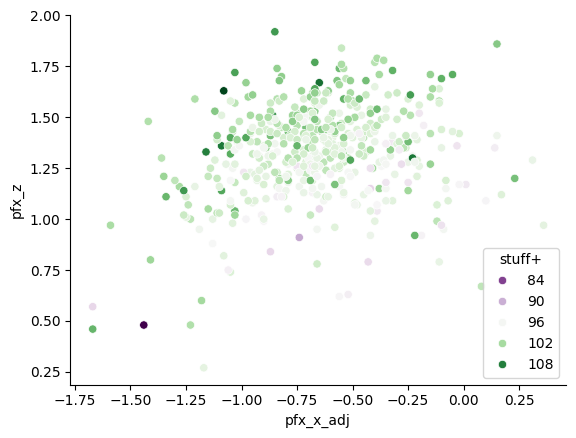

In [ ]:
sns.scatterplot(data=df.loc[df['pitch_type']=='FF'].sample(500),
                x='pfx_x_adj', y='pfx_z',hue='stuff+', palette='PRGn')
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

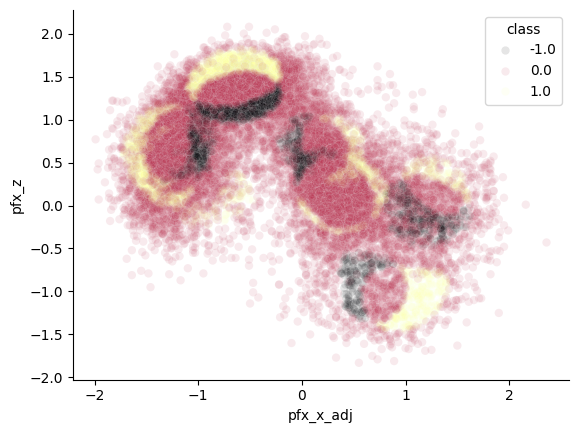

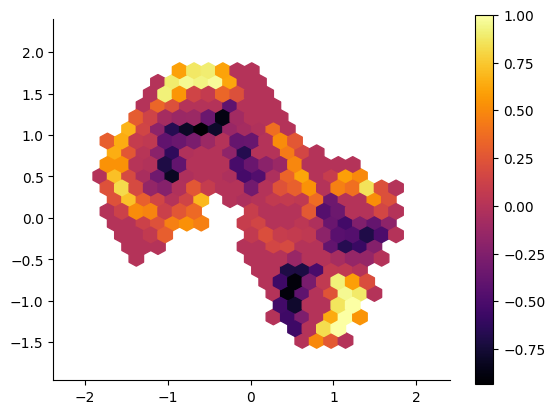

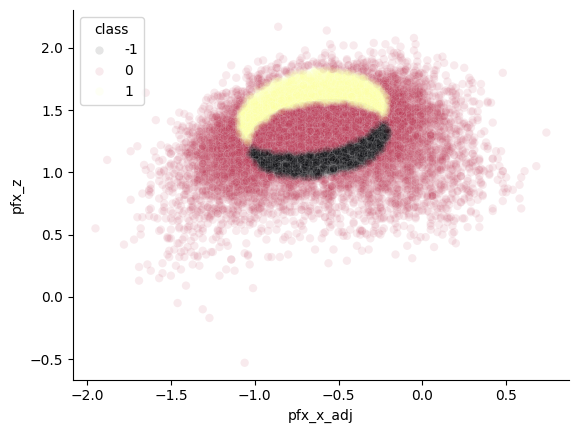

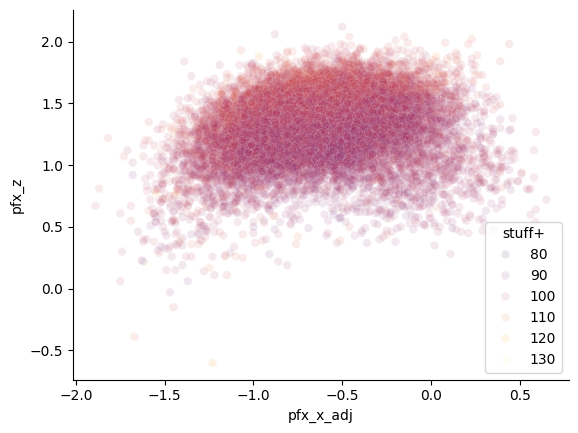

In [ ]:
sns.scatterplot(data=df.sample(20000),
                x='pfx_x_adj', y='pfx_z',
                hue='class', palette='inferno',alpha=.1)
sns.despine()
plt.show()

hb = plt.hexbin(data=df.sample(20000),
                x='pfx_x_adj', y='pfx_z',
                C='class',cmap='inferno',
                mincnt=10,gridsize=25)
sns.despine()
plt.colorbar(hb)
plt.gca().set_aspect('equal')
plt.show()

sns.scatterplot(data=df.loc[df['pitch_type']=='FF'].sample(20000),
                x='pfx_x_adj', y='pfx_z',
                hue='class', palette='inferno',alpha=.1)
sns.despine()
plt.show()

sns.scatterplot(data=df.loc[df['pitch_type']=='FF'].sample(20000),
                x='pfx_x_adj', y='pfx_z',
                hue='stuff+', palette='inferno',alpha=.1)
sns.despine()
plt.show()

In [ ]:
pid = 434378
df_agg = df.loc[(df['pitcher']==pid) & (df['game_year']==2024)].copy()
df_agg = df_agg.loc[:, ['pitcher','player_name','pitch_type', 'stuff+', 'pfx_x_adj', 'pfx_z']].dropna().groupby(['pitcher','player_name','pitch_type'], as_index=False).mean()
df_agg['pfx_x_adj'] = df_agg['pfx_x_adj'].mul(12)
df_agg['pfx_z'] = df_agg['pfx_z'].mul(12)
df_agg

<IPython.core.display.Javascript object>

,pitcher,player_name,pitch_type,stuff+,pfx_x_adj,pfx_z
0,434378,"Verlander, Justin",CH,102.583972,-13.431000,9.701250
1,434378,"Verlander, Justin",CU,101.055271,7.230867,-13.433410
2,434378,"Verlander, Justin",FF,102.318289,-8.602883,19.303329
3,434378,"Verlander, Justin",SI,98.313056,-11.840000,16.500000
4,434378,"Verlander, Justin",SL,102.046705,4.001705,5.914230


In [ ]:
df_agg = df.loc[(df['pitcher']==pid) & (df['game_year']==2024)].copy()

<IPython.core.display.Javascript object>

In [ ]:
_df1 = df_agg.loc[:, ['stand', 'des']].groupby(['stand'], as_index=False).count().rename(columns={'des':'count'})
_df2 = df_agg.loc[:, ['stand', 'pitch_name', 'des']].groupby(['stand', 'pitch_name'], as_index=False).count()
_df = _df2.merge(_df1)
_df['%'] = (_df['des'].div(_df['count'])).mul(100).round(0)
_df

<IPython.core.display.Javascript object>

,stand,pitch_name,des,count,%
0,L,4-Seam Fastball,383,815,47.0
1,L,Changeup,116,815,14.0
2,L,Curveball,186,815,23.0
3,L,Slider,130,815,16.0
4,R,4-Seam Fastball,380,765,50.0
5,R,Changeup,44,765,6.0
6,R,Curveball,160,765,21.0
7,R,Sinker,6,765,1.0
8,R,Slider,175,765,23.0


<IPython.core.display.Javascript object>

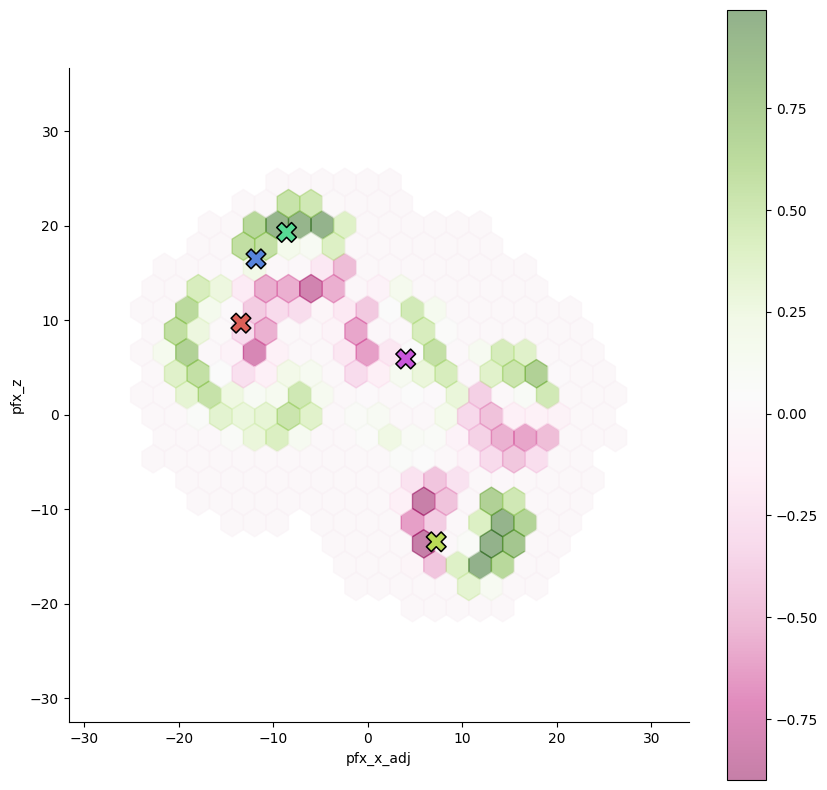

In [ ]:
df_plt = df.sample(500000)
df_plt['pfx_x_adj'] = df_plt['pfx_x_adj'].mul(12)
df_plt['pfx_z'] = df_plt['pfx_z'].mul(12)

fig = plt.figure(figsize=(10,10))
fig = plt.hexbin(data=df_plt,
                x='pfx_x_adj', y='pfx_z',
                C='class',cmap='PiYG',alpha=.5,
                mincnt=10,gridsize=25, zorder=1)

sns.scatterplot(data=df_agg,
                x='pfx_x_adj', y='pfx_z',
                hue='pitch_type', palette='hls',marker='X',
                edgecolor='k',zorder=2, s=200)
sns.despine()
plt.legend().set_visible(False)
plt.colorbar(fig)
plt.gca().set_aspect('equal')
plt.show()